## Calculation of bleed-through signal ratios of fluorophores in different channels of three-colour imaging
### QD740, KK114, and Alexa594

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import scipy.stats as st
from PIL import Image
from skimage import filters
import os

In [497]:
# read image paths - for the different channels
paths_qd = os.listdir()
paths_qd = [path for path in paths_qd if 'qd' in path]
paths_qdso = os.listdir()
paths_qdso = [path for path in paths_qdso if 'qso' in path]
paths_ves = os.listdir()
paths_ves = [path for path in paths_ves if 'ves' in path]
paths_tub = os.listdir()
paths_tub = [path for path in paths_tub if 'tub' in path]
print(len(paths_qd))

# set pixel dwell times
dt_qd = 50  # µs
dt_tub = 30  # µs
dt_ves = 30  # µs

bleedthroughs = []

7


Bleedthrough of tubulin in 3 channels: [1.         0.05832538 0.27156816]
Bleedthrough of QD in 3 channels:      [0.12528813 1.         0.11310263]
Bleedthrough of LAMP1 in 3 channels:   [0.09195065 0.01892633 1.        ]
                                          Tub          QD        VES
Bleedthrough of tubulin in 3 channels: [1.         0.11013056 0.16624459]
Bleedthrough of QD in 3 channels:      [0.00221053 1.         0.01043729]
Bleedthrough of LAMP1 in 3 channels:   [0.10871935 0.05609116 1.        ]
                                          Tub          QD        VES
Bleedthrough of tubulin in 3 channels: [1.         0.05353594 0.06490554]
Bleedthrough of QD in 3 channels:      [0.23498062 1.         0.0872093 ]
Bleedthrough of LAMP1 in 3 channels:   [0.11564462 0.04597968 1.        ]
                                          Tub          QD        VES
Bleedthrough of tubulin in 3 channels: [1.         0.04015473 0.13756615]
Bleedthrough of QD in 3 channels:      [0.1814059  1.

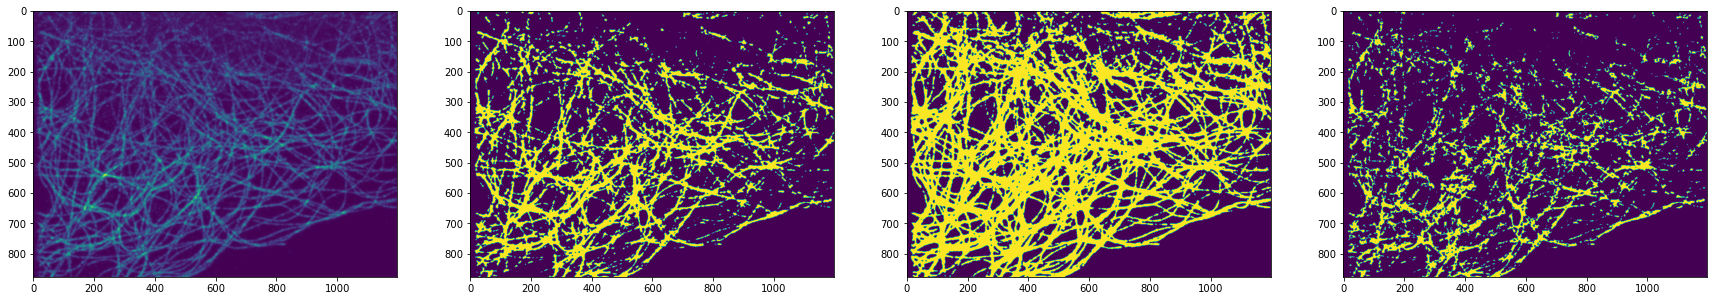

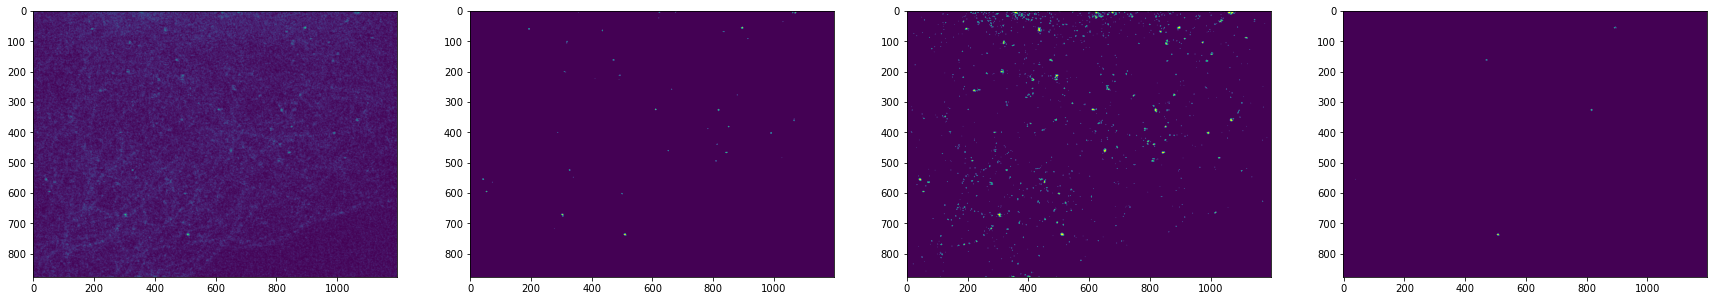

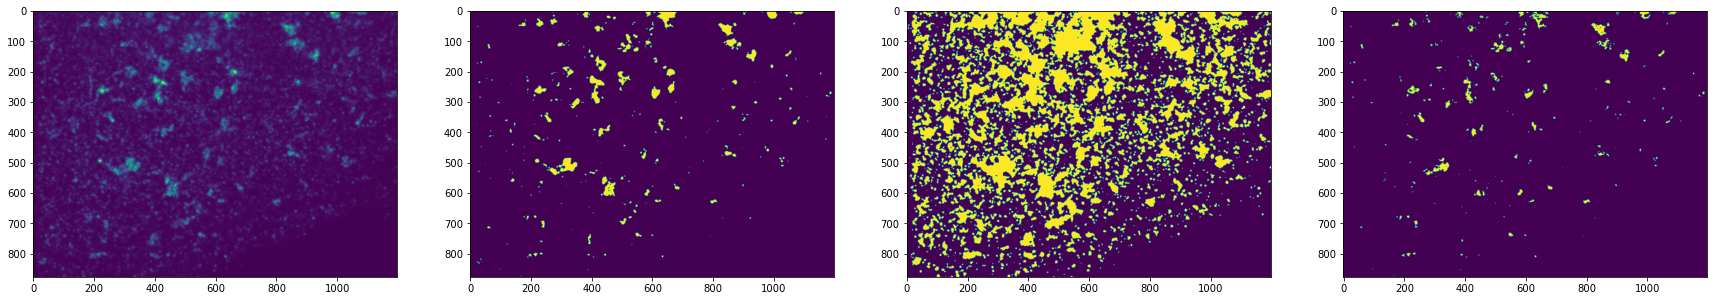

In [501]:
# loop bleed-through calculations over all images
for path_idx in range(len(paths_qd)):
    # read images
    path_qd = paths_qd[path_idx]
    path_qdso = paths_qdso[path_idx]
    path_ves = paths_ves[path_idx]
    path_tub = paths_tub[path_idx]
    img_qd = np.array(Image.open(path_qd)).astype('uint32')
    img_qdso = np.array(Image.open(path_qdso)).astype('uint32')
    img_ves = np.array(Image.open(path_ves)).astype('uint32')
    img_tub = np.array(Image.open(path_tub)).astype('uint32')
    
    # calculate binary images, hi and lo, for tubulin (Alexa594)
    img_tub = img_tub - img_qdso
    img_tub[img_tub > 1e6] = 0
    img_tub_sm = filters.gaussian(img_tub, sigma=2, preserve_range=True)
    th_tub = filters.threshold_otsu(img_tub_sm)  # Otsu: *1.1 (hi), *0.8 (lo)
    th_tub_lo = th_tub * 0.6
    th_tub_hi = th_tub * 1.1
    img_tub_bin_lo = img_tub_sm > th_tub_lo
    img_tub_bin = img_tub_sm > th_tub_hi

    # calculate binary images, hi and lo, for QDs (QD740)
    img_qd = img_qd - img_qdso
    img_qd[img_qd > 1e6] = 0
    img_qd_sm = filters.gaussian(img_qd, sigma=1, preserve_range=True)
    th_qd = filters.threshold_triangle(img_qd_sm)  # Triangle: *2.3 (hi), *1.3 (lo) | Yen: *0.8 (hi), *0.5 (lo)
    th_qd_lo = th_qd * 1.1
    th_qd_hi = th_qd * 2.1
    img_qd_bin_lo = img_qd_sm > th_qd_lo
    img_qd_bin = img_qd_sm > th_qd_hi
    
    # calculate binary images, hi and lo, for vesicles (KK114)
    img_ves = img_ves - img_qdso
    img_ves[img_ves > 1e6] = 0
    img_ves_sm = filters.gaussian(img_ves, sigma=2, preserve_range=True)
    th_ves = filters.threshold_triangle(img_ves_sm)  # Triangle: *2 (hi), *1.3 (lo)
    th_ves_lo = th_ves * 0.4
    th_ves_hi = th_ves * 2
    img_ves_bin_lo = img_ves_sm > th_ves_lo
    img_ves_bin = img_ves_sm > th_ves_hi

    # calculate areas A_i from which to extract the signal for each individual fluorophore
    img_tub_bin_only = img_tub_bin & ~(img_qd_bin_lo | img_ves_bin_lo)
    img_qd_bin_only = img_qd_bin & ~(img_ves_bin_lo | img_tub_bin_lo)
    img_ves_bin_only = img_ves_bin & ~(img_qd_bin_lo | img_tub_bin_lo)

    # compare fluorophore signal in the different channels - normalized to pixel dwell time
    sig_tub = [np.mean(img_tub[img_tub_bin_only])/dt_tub, np.mean(img_qd[img_tub_bin_only])/dt_qd, np.mean(img_ves[img_tub_bin_only])/dt_ves]
    sig_qd = [np.mean(img_tub[img_qd_bin_only])/dt_tub, np.mean(img_qd[img_qd_bin_only])/dt_qd, np.mean(img_ves[img_qd_bin_only])/dt_ves]
    sig_ves = [np.mean(img_tub[img_ves_bin_only])/dt_tub, np.mean(img_qd[img_ves_bin_only])/dt_qd, np.mean(img_ves[img_ves_bin_only])/dt_ves]
    bleed_tub = sig_tub/sig_tub[0]
    bleed_qd = sig_qd/sig_qd[1]
    bleed_ves = sig_ves/sig_ves[2]
    bleedthroughs.append(np.vstack([bleed_tub,bleed_qd,bleed_ves]))

    print(f'Bleedthrough of tubulin in 3 channels: {bleed_tub}')
    print(f'Bleedthrough of QD in 3 channels:      {bleed_qd}')
    print(f'Bleedthrough of LAMP1 in 3 channels:   {bleed_ves}')
    print('                                          Tub          QD        VES')

    if path_idx in [0,1]:
        fig, axs = plt.subplots(1,4,figsize=(30,7))
        axs[0].imshow(img_tub_sm)
        axs[1].imshow(img_tub_bin)
        axs[2].imshow(img_tub_bin_lo)
        axs[3].imshow(img_tub_bin_only)

        fig, axs = plt.subplots(1,4,figsize=(30,7))
        axs[0].imshow(img_qd_sm)
        axs[1].imshow(img_qd_bin)
        axs[2].imshow(img_qd_bin_lo)
        axs[3].imshow(img_qd_bin_only)

        fig, axs = plt.subplots(1,4,figsize=(30,7))
        axs[0].imshow(img_ves_sm)
        axs[1].imshow(img_ves_bin)
        axs[2].imshow(img_ves_bin_lo)
        axs[3].imshow(img_ves_bin_only)

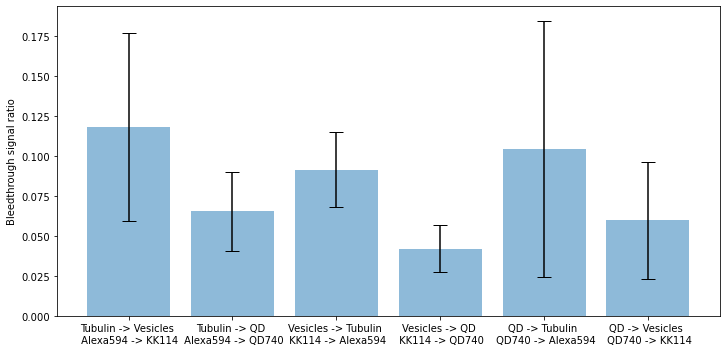

In [503]:
# get and plot mean and std for the bleed-through ratios
tub_to_qd = [mat[0][1] for mat in bleedthroughs]
tub_to_ves = [mat[0][2] for mat in bleedthroughs]
qd_to_tub = [mat[1][0] for mat in bleedthroughs]
qd_to_ves = [mat[1][2] for mat in bleedthroughs]
ves_to_tub = [mat[2][0] for mat in bleedthroughs]
ves_to_qd = [mat[2][1] for mat in bleedthroughs]

bleed_labels = ['Tubulin -> Vesicles \n Alexa594 -> KK114', 'Tubulin -> QD \n Alexa594 -> QD740', 'Vesicles -> Tubulin \n KK114 -> Alexa594', 'Vesicles -> QD \n KK114 -> QD740', 'QD -> Tubulin \n QD740 -> Alexa594', 'QD -> Vesicles \n QD740 -> KK114']
bleed_means = [np.mean(tub_to_ves),np.mean(tub_to_qd),np.mean(ves_to_tub),np.mean(ves_to_qd),np.mean(qd_to_tub),np.mean(qd_to_ves)]
bleed_std = [np.std(tub_to_ves),np.std(tub_to_qd),np.std(ves_to_tub),np.std(ves_to_qd),np.std(qd_to_tub),np.std(qd_to_ves)]

fig = plt.figure(figsize=(10,5))
plt.bar(bleed_labels, bleed_means, yerr=bleed_std, alpha=0.5, capsize=7)
plt.tight_layout()
plt.ylabel('Bleedthrough signal ratio')
#plt.savefig('bleedthrough-3col.svg')